# ML HOMEWORK II

## Importing and loading dependencies and libraries

In [1]:
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
import numpy as np
from collections import Counter
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                         UpSampling2D, BatchNormalization, Lambda
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import gdown
import zipfile
import os
import pathlib

print('Dependencies loaded\n')

print("Tensorflow version %s" %tf.__version__)
print("tf.Keras version %s" %tf.keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Dependencies loaded

Tensorflow version 2.9.2
tf.Keras version 2.9.0
Found GPU at: /device:GPU:0


## Downloading the dataset

In [3]:
output='dataset.zip'
id='1rw-YwHUzUtkiRZ9y9QHc6SqTbnv2fejV'

dataset_url = 'https://drive.google.com/uc?id=' + id + '&export=download&confirm=t'
gdown.download(dataset_url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1rw-YwHUzUtkiRZ9y9QHc6SqTbnv2fejV&export=download&confirm=t
To: /content/dataset.zip
100%|██████████| 615M/615M [00:04<00:00, 135MB/s]


'dataset.zip'

## Extracting the previous downloaded file

In [4]:
zip_file_path = '/content/dataset.zip'  # the path to the zip file downloaded before
destination_folder = '/content' # the destination folder

print('Extracting the zipped dataset')

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
     zip_ref.extractall(destination_folder)
print('Deleting the previous downloaded zip')
os.remove('dataset.zip')
print('--Deleted')

Extracting the zipped dataset
Deleting the previous downloaded zip
--Deleted


## Checking the integrity 

In [5]:
data_dir = '/content/dataset'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print('Total number of dataset images:', image_count)

Total number of dataset images: 6862


## Images distribution of the dataset

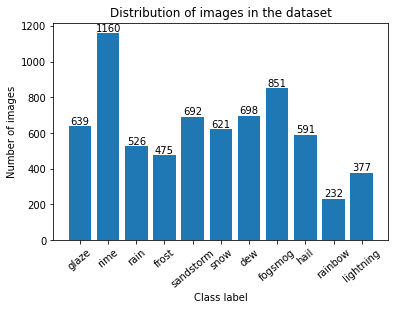

In [6]:
# Get the list of subdirectories in the dataset directory

subdirs = [x[0] for x in os.walk(data_dir)]

# Remove the top-level directory from the list of subdirectories
subdirs = subdirs[1:]

# Initialize lists to store the file paths and labels
filepaths = []
labels = []

# Loop through the subdirectories and add the file paths and labels to the lists
for subdir in subdirs:
    class_label = os.path.basename(subdir)
    for file in os.listdir(subdir):
        filepath = os.path.join(subdir, file)
        filepaths.append(filepath)
        labels.append(class_label)

# Count the number of images in each class

class_counts = Counter(labels)

# Get the class labels and the number of images in each class
class_labels, class_counts = zip(*class_counts.items())

# Plot the distribution of images in the dataset
plt.bar(class_labels, class_counts)
plt.xlabel('Class label')
plt.ylabel('Number of images')
plt.xticks(rotation=40)
for x, y in zip(class_labels, class_counts):
    plt.text(x, y, '%d' % y, ha='center', va='bottom')
plt.title('Distribution of images in the dataset')
plt.show()

## Making the dataset

### Parameters for data augmentation of the subsets

In [7]:
batch_size = 8
img_height = 225
img_width = 317
seed=123

train_datagen = ImageDataGenerator(
        rescale = 1. / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.3)

val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.3)

### Creating the training dataset

In [8]:
train_ds = train_datagen.flow_from_directory(
    directory = data_dir,  # The directory containing the dataset
    target_size=(img_height, img_width),  # The size to resize images to
    batch_size=batch_size,  # The batch size for training
    class_mode="categorical",  # The type of label
    shuffle = True, # Shuffle the items
    subset="training",  # The subset to use for training
    seed=seed
)

Found 4808 images belonging to 11 classes.


### Creating the test dataset

In [9]:
val_ds = val_datagen.flow_from_directory(
    directory = data_dir,  # The directory containing the dataset
    target_size=(img_height, img_width),  # The size to resize images to
    batch_size=batch_size,  # The batch size for training
    class_mode="categorical",  # The type of label
    shuffle = False, # Shuffle the items
    subset="validation",  # The subset to use for training
)

Found 2054 images belonging to 11 classes.


### Checking the integrity of the previous splits and printing some information

#### Checking integrity

In [10]:
# Lists of file paths for the training and validation sets
train_file_paths = []
validation_file_paths = []

for (root, dirs, files) in os.walk(data_dir):
    subdir = os.path.basename(root)     # To find the subdirectory name (the class label)
    for file in files:
        file_path = os.path.join(subdir, file)
        if subdir == 'training':
            train_file_paths.append(file_path)
        elif subdir == 'validation':
            validation_file_paths.append(file_path)

# Check for overlaps between the training and validation sets
overlap = set(train_file_paths).intersection(validation_file_paths)
if len(overlap) > 0:
    print('Warning: There are {} overlaps between the training and validation sets:'.format(len(overlap)))
    print(*overlap, sep='\n')
else:
    print('No overlaps between the training and validation sets.')

No overlaps between the training and validation sets.


#### Some information

In [11]:
# Some useful information
num_samples = train_ds.n
num_classes = train_ds.num_classes
input_shape = train_ds.image_shape

class_names = [k for k,v in train_ds.class_indices.items()]

print("Image input: %s" %str(input_shape))
print("Classes: %r" %class_names)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(val_ds.n,val_ds.num_classes))


Image input: (225, 317, 3)
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Loaded 4808 training samples from 11 classes.
Loaded 2054 test samples from 11 classes.


### Checking the integrity of the batches

In [12]:
#  Iteration over the dataset to retrieve batches of images

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)    # Expected tensor of the shape (batch_size, image_height, image_width, channel_color)
  print(labels_batch.shape)   # Expected tensor of the shape (batch_size, num_classes) corresponding to labels of the images
  break

(8, 225, 317, 3)
(8, 11)


### Show some random samples

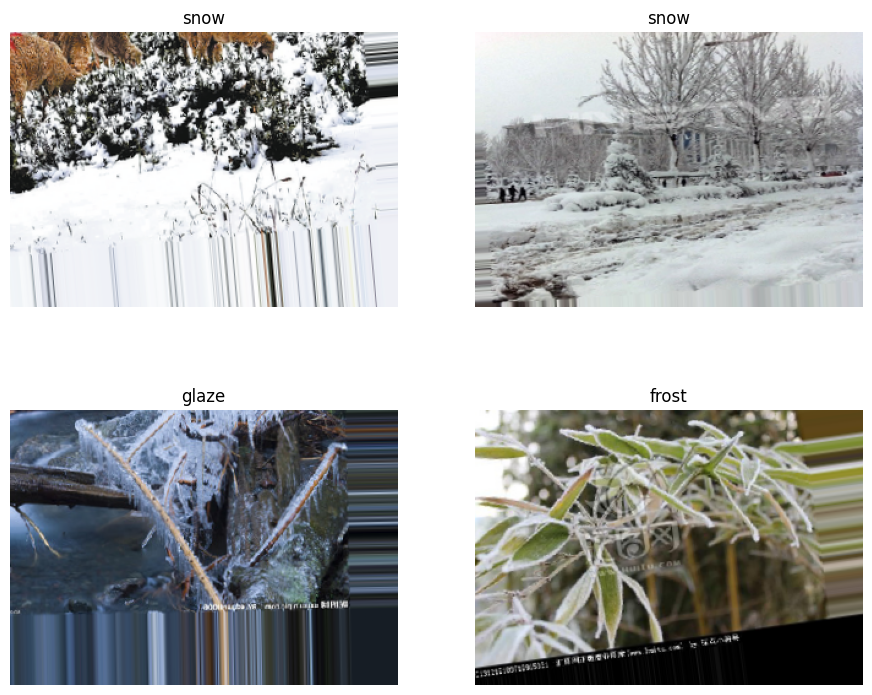

In [ ]:
x,y = train_ds.next()
plt.figure(figsize=(11, 9))
for i in range(0,4):
  ax = plt.subplot(2, 2, i + 1)
  image = x[i]
  label = y[i].argmax()  # categorical from one-hot-encoding
  plt.title(class_names[label])
  plt.imshow(image)
  plt.axis('off')
plt.show()

## Preparing the network

### Buffered prefetching

Not used because it makes it impossible to get datasets labels in the evaluation phase

In [ ]:
# Use buffered prefetching to load images from disk without having I/O become blocking

# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Choosing networks

#### DenseNet121

The DenseNet121 model is characterized by its 121-layer network, which is made up of a series of dense blocks. Each dense block contains a number of convolutional layers, with each layer receiving input from all preceding layers in the block. This allows the model to learn more robust and discriminative features, as the information from the earlier layers is directly passed on to the later layers.
The DenseNet121 model also includes skip connections, which allow the model to bypass a layer and directly connect the input to the output. This helps to alleviate the vanishing gradient problem, where the gradients of the earlier layers become very small as they are backpropagated through the network, making it difficult to update their weights

The model used is a slightly modified DenseNet121 network: the top of the network has been replaced with 11 custom layers to perform the final classification by reducing the number of neurons in each fully-connected layer 

In [21]:
# Model definition

modelDN = tf.keras.applications.DenseNet121(include_top = False, classes=11, input_shape=input_shape)

# get the output tensor from a layer of the feature extractor
input_DN = modelDN.get_layer(index=0).input

output_extractor = modelDN.output

# flat the output of previous layer
flatten = Flatten(name='Start_of_the_customTop')(output_extractor) 
flatten_norm = BatchNormalization()(flatten)

# add a Dense layer
dense1 = Dropout(0.4)(flatten_norm)
dense1 = Dense(200, activation='relu')(dense1)
dense1 = BatchNormalization()(dense1)

# add a Dense layer
dense2 = Dropout(0.4)(dense1)
dense2 = Dense(100, activation='relu')(dense2)
dense2 = BatchNormalization()(dense2)

# add the final output layer
dense3 = BatchNormalization()(dense2)
dense3 = Dense(num_classes, activation='softmax')(dense3)

model = tf.keras.models.Model(inputs=input_DN, outputs=dense3, name="CustomDN")

# Fine-tuning
Fine_tuning = True

if (Fine_tuning == True):
  for layer in model.layers[:100]:
    layer.trainable = False
  for layer in model.layers[100:]:
    layer.trainable = True
elif (Fine_tuning == False):
  for layer in model.layers[:-11]:
      layer.trainable = False

#model.summary()

# history of results (set to None when initializing a new model)
history = None

model_name = model._name
print (f'Model loaded: {model_name}')

Model loaded: CustomDN


#### Custom Model

This model has three convolutional layers, each followed by a max pooling layer and a dropout layer to reduce overfitting. The output of the convolutional layers is flattened and passed through a fully connected layer with 512 nodes, followed by another dropout layer. The final layer is an output layer with 11 nodes, one for each class, and uses the softmax activation function to produce probabilities for each class.

In [14]:
from keras.regularizers import l2

# define the model
inputs = Input(shape=input_shape)

# add the first convolutional layer
x = Conv2D(filters=32, kernel_size=(3,3), kernel_regularizer= l2(0.001), activation='relu')(inputs)    # the layer has 32 filters, that are 3x3 matrices
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# add the second convolutional layer
x = Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer= l2(0.001), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# add the third convolutional layer
x = Conv2D(filters=128, kernel_size=(3,3), kernel_regularizer= l2(0.001), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# flatten the output and add a fully connected layer
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# add the output layer
predictions = Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=predictions, name='CustomModel')

# model.summary()

# history of results (set to None when initializing a new mdoel)
history = None

model_name = model._name
print (f'Model loaded: {model_name}')

Model loaded: CustomModel


## Compiling the choosen model

In [22]:
model.compile(
  optimizer='adam', # optimizer
  loss=tf.keras.losses.CategoricalCrossentropy(), # loss function
  metrics=['accuracy']) # metric to track

### Callbacks definitions

In [23]:
# Defining some useful callbacks
if model_name == 'CustomDN':
    checkpoint = ModelCheckpoint(filepath='/content/DenseNet/DNmodel_ep{epoch:02d}.h5',
                                monitor='val_accuracy', # choosen metrics to evaluate
                                mode='max',    # the model will be saved if the monitored metric has a higher value at the end of the epoch than the previous best
                                save_best_only=True,   # save only the model with the best metrics value 
                                save_weights_only= False)  # to save the entire model (mainly to access to history after loading of a saved model)
elif model_name == 'CustomModel':
    checkpoint = ModelCheckpoint(filepath='/content/Custom Model/CMmodel_ep{epoch:02d}.h5',
                                monitor='val_accuracy', # choosen metrics to evaluate
                                mode='max',    # the model will be saved if the monitored metric has a higher value at the end of the epoch than the previous best
                                save_best_only=True,   # save only the model with the best metrics value 
                                save_weights_only= False)  # to save the entire model (mainly to access to history after loading of a saved model)

lr_callback = ReduceLROnPlateau(monitor='val_loss', # the metric to be monitored for reducing the learning rate
                                patience=3, # the number of epochs to wait before reducing the learning rate
                                factor=0.1, # factor by which the learning rate will be reduced
                                min_lr=1e-6, # lower bound of the learning rate
                                max_lr=1e-2)  # upper bound of the learning rate

early_stopping = EarlyStopping(monitor='val_loss', # the metric to be monitored for early stopping
                               patience=6,  # the number of epochs to wait before stopping the training when the metric stops improving
                               mode = 'min',    # the mode in which to monitor the metric: minimum value of the metric
                               min_delta=0.006, # the minimum change in the monitored metric to qualify as an improvement
                               restore_best_weights=True)   # if restore the model weights from the epoch with the best performance on the monitored metric

## Training the network

In [24]:
steps_per_epoch=train_ds.n//train_ds.batch_size
val_steps=val_ds.n//val_ds.batch_size+1

m = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30,
  steps_per_epoch=steps_per_epoch,
  validation_steps=val_steps,
  callbacks=[checkpoint, lr_callback, early_stopping]) 

if history is None:
    history = m.history
else:
    history['loss'].extend(m.history['loss'])
    history['accuracy'].extend(m.history['accuracy'])
    history['val_loss'].extend(m.history['val_loss'])
    history['val_accuracy'].extend(m.history['val_accuracy'])

Epoch 1/30
601/601 [==============================] - 145s 224ms/step - loss: 1.3293 - accuracy: 0.5666 - val_loss: 0.8067 - val_accuracy: 0.7926 - lr: 0.0010
Epoch 2/30
274/601 [============>.................] - ETA: 1:03 - loss: 0.9480 - accuracy: 0.7016

KeyboardInterrupt: ignored

### Plotting the results

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model evaluation

In [27]:
print('Model:', model_name)

switch = 2 # select from [1,2]

if model_name == 'CustomDN':
    if switch == 1:
      output='no-fine_model_ep22.h5'
      id='1sH1JiPXIAiHwcXXuWTKyMp1SWHUgjmsN'
      dataset_url = 'https://drive.google.com/uc?id=' + id + '&export=download&confirm=t'
      gdown.download(dataset_url, output, quiet=False)
      best_model = load_model('/content/no-fine_model_ep22.h5')
    elif switch== 2:
      output='fine_tuned_model_ep19.h5'
      id='1sGrFktBAMnz06OHaB0blMP_b_GOfaSX0'
      dataset_url = 'https://drive.google.com/uc?id=' + id + '&export=download&confirm=t'
      gdown.download(dataset_url, output, quiet=False)
      best_model = load_model('/content/fine_tuned_model_ep19.h5')
elif model_name == 'CustomModel':
    if switch == 1:
      output='conv_reg_customModel_ep26.h5'
      id='1sI_LyvcyFR6CDPDMzkv0F7kNj8eqkXRE'
      dataset_url = 'https://drive.google.com/uc?id=' + id + '&export=download&confirm=t'
      gdown.download(dataset_url, output, quiet=False)
      best_model = load_model('/content/conv_reg_customModel_ep26.h5')
    elif switch== 2:
      output='conv_no_reg_customModel_ep20.h5'
      id='1sHo0Mx5qcxC9ck90XgK1FlesmQ7qxV_J'
      dataset_url = 'https://drive.google.com/uc?id=' + id + '&export=download&confirm=t'
      gdown.download(dataset_url, output, quiet=False)
      best_model = load_model('/content/conv_no_reg_customModel_ep20.h5')

results = best_model.evaluate(val_ds)
print(f"Accuracy: {results[-1]:.3f} \nLoss: {results[-2]:.3f}")


Model: CustomDN


Downloading...
From: https://drive.google.com/uc?id=1sGrFktBAMnz06OHaB0blMP_b_GOfaSX0&export=download&confirm=t
To: /content/fine_tuned_model_ep19.h5
100%|██████████| 254M/254M [00:02<00:00, 94.3MB/s]


257/257 [==============================] - 18s 62ms/step - loss: 0.3070 - accuracy: 0.9070
Accuracy: 0.907 
Loss: 0.307


In [28]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=val_ds.n//val_ds.batch_size+1
preds = best_model.predict(val_ds,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = val_ds.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=class_names, digits=3))

257/257 [==============================] - 17s 61ms/step
              precision    recall  f1-score   support

         dew      0.948     0.962     0.955       209
     fogsmog      0.921     0.965     0.943       255
       frost      0.743     0.894     0.812       142
       glaze      0.816     0.906     0.859       191
        hail      0.966     0.955     0.960       177
   lightning      0.991     1.000     0.996       113
        rain      0.921     0.892     0.906       157
     rainbow      0.986     1.000     0.993        69
        rime      0.923     0.859     0.890       348
   sandstorm      0.979     0.908     0.942       207
        snow      0.836     0.742     0.786       186

    accuracy                          0.907      2054
   macro avg      0.912     0.917     0.913      2054
weighted avg      0.910     0.907     0.907      2054



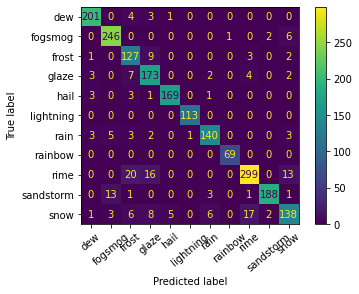

True                Predicted          	errors	err %    
------------------------------------------------------------------------
rime             -> frost              	20     	0.97 % 
snow             -> rime               	17     	0.83 % 
rime             -> glaze              	16     	0.78 % 
sandstorm        -> fogsmog            	13     	0.63 % 
rime             -> snow               	13     	0.63 % 
frost            -> glaze              	9     	0.44 % 
snow             -> glaze              	8     	0.39 % 
glaze            -> frost              	7     	0.34 % 
snow             -> rain               	6     	0.29 % 
snow             -> frost              	6     	0.29 % 
fogsmog          -> snow               	6     	0.29 % 
rain             -> fogsmog            	5     	0.24 % 
snow             -> hail               	5     	0.24 % 
dew              -> frost              	4     	0.19 % 
glaze            -> rime               	4     	0.19 % 
frost            -> rime               	

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(Ytest, Ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=40)

plt.show()

conf = []
for i in range(0, cm.shape[0]):
    for j in range(0, cm.shape[1]):
        if (i != j and cm[i][j]>0):
            conf.append([i,j,cm[i][j]])
            
col=2
conf = np.array(conf)
conf= conf[np.argsort(-conf[:,col])]

print('%-16s    %-16s   \t%s\t%s    ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------------')
for k in conf:
    print('%-16s -> %-16s   \t%d     \t%.2f %% ' %(class_names[k[0]],class_names[k[1]],k[2],k[2]*100.0/val_ds.n))